# Cloud DCGAN

## Setup

In [3]:
# Imports

import sagemaker
import boto3
import argparse
import json
import os
import sys
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets
from sagemaker.pytorch import PyTorch

import config
from train.model import DataDiscriminator, DataGenerator
from train.train import get_dataloader, weights_init_normal, train, build_network, fake_loss, real_loss, model_fn, scale


In [4]:
# Directories

imgs_path = '/Volumes/SKYFLASH/fromReddit/'
model_dir = '/Volumes/SKYFLASH/models/'

# Model hyperparameters
# Chosen based on https://arxiv.org/pdf/1511.06434.pdf

batch_size = 32
img_size = 32
z_size = 100
conv_dim = 32
lr = 0.0002
beta1 =0.5
beta2 = 0.999
epochs = 20


In [ ]:
# # Sagemaker session

# sagemaker_session = sagemaker.Session(boto3.session.Session(
#     aws_access_key_id=config.aws_access_key_id,
#     aws_secret_access_key=config.aws_secret_access_key,
#     region_name=config.aws_region_name))


# bucket = sagemaker_session.default_bucket()

# prefix = 'sagemaker/dcgan'

# role = 'sagemaker_execution_role'

In [5]:
# Upload training data to S3 bucket 
# input_data = sagemaker_session.upload_data(path=imgs_path, bucket=bucket, key_prefix=prefix)
input_data = 's3://sagemaker-us-west-1-751070674002/sagemaker/dcgan' # If training data uploaded and this url updated

## Build/train model 

In [6]:
# Load data
train_loader = get_dataloader(batch_size, img_size, imgs_path)


/Users/acavet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


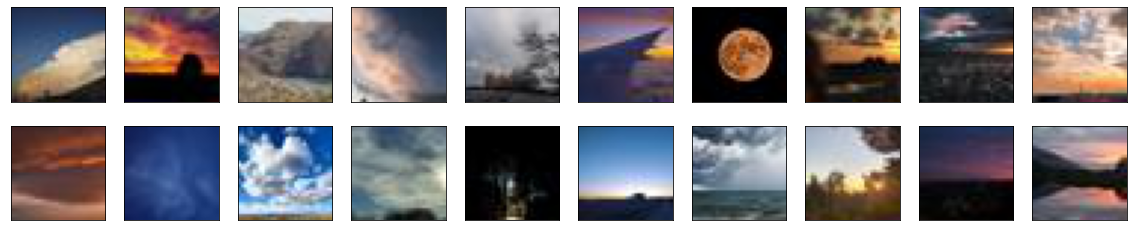

In [7]:
# Helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# One batch of training images
dataiter = iter(train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot batch images and labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    

In [8]:
# Build model on local cpu

device = torch.cuda.is_available()

D, G = build_network(conv_dim, conv_dim, z_size)

# optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

train(D, G, z_size, train_loader, epochs, d_optimizer, g_optimizer, device)

# save model parameters
G_path = os.path.join(model_dir, 'generator_model.pt')
with open(G_path, 'wb') as f:
    torch.save(G.cpu().state_dict(), f)

DataDiscriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

DataGenerator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   20] | d_loss: 1.2636 | g_loss: 1.3035
Epoch [    1/   20] | d_loss: 0.1321 | g_loss: 7.1040
Epoch [    1/   20] | d_loss: 0.7272 | g_loss: 1.8599
Epoch [    1/   20] | d_loss: 0.6355 | g_loss: 1.9322
Epoch [    1/   20] | d_loss: 0.8485 | g_loss: 5.4988
Epoch [    1/   20] | d_loss: 0.4841 | g_loss: 1.8204
Epoch [    1/   20] | d_loss: 0.7888 | g_loss: 1.1849
Epoch [    1/   20] | d_loss: 0.9075 | g_loss: 1.4416
Epoch [    2/   20] | d_loss: 0.6431 | g_loss: 2.1700
Epoch [    2/   20] | d_loss: 0.5190 | g_loss: 2.1037
Epoch [    2/   20] | d_loss: 0.9610 | g_loss: 1.2884
Epoch [    2/   20] | d_loss: 1.2430 | g_loss: 1.9626
Epoch [    2/   20] | d_loss: 0.5496 | g_loss: 2.2261
Epoch [    2/   20] | d_loss: 0.5987 | g_loss: 1.7858
Epoch [    2/   20] | d_loss: 0.7191 | g_loss: 2.1897
Epoch [    2/   20] | d_loss: 0.8010 | g_loss: 1.6611
Epoch [    3/   20] | d_loss: 1.8706 | g_loss: 3.3216
Epoch [    3/   20] | d_loss: 1.0620 | g_loss: 1.9936
Epoch [    3/   20] | d_loss

In [ ]:
# # Set up Sagemaker Pytorch model for training 

# estimator = PyTorch(entry_point="train.py",
#                     source_dir="train",
#                     role=role,
#                     py_version="py3",
#                     framework_version='1.5.0',
#                     instance_count=1,
#                     instance_type='ml.m5.4xlarge',
#                     hyperparameters={
#                         'epochs': 20,
#                         'conv_dim': 64,
#                     })

In [ ]:
# # Train Sagemaker Pytorch model
# estimator.fit({'training': input_data})


In [ ]:
# estimator = estimator.attach('sagemaker-pytorch-2021-07-28-22-01-47-575')

In [11]:
# # Deploy
# predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

# Deploy (if on local cpu)
model = DataGenerator(z_size=z_size,conv_dim=conv_dim)
model.cpu()

DataGenerator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (dconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
# # Input noise
# fixed_z = np.random.uniform(-1, 1, size=(16, 100))
# fixed_z = torch.from_numpy(fixed_z).float()

# # Get sample generations
# sample_y = predictor.predict(fixed_z)


In [ ]:
# # See generated results

# def view_samples(epoch, samples):
#     fig, axes = plt.subplots(figsize=(img_size,8), nrows=4, ncols=8, sharey=True, sharex=True)

#     for ax, img in zip(axes.flatten(), samples):
        
#         img = img.detach().cpu().numpy()
#         img = np.transpose(img, (1, 2, 0))
#         img = ((img + 1)*255 / (2)).astype(np.uint8)
#         ax.xaxis.set_visible(False)
#         ax.yaxis.set_visible(False)
#         im = ax.imshow(img.reshape((32,32,3)))

# _ = view_samples(-1, sample_y)

In [27]:
# Helper function to see results
def view_samples(samples):
    n_cols = 8
    fig, axes = plt.subplots(figsize=(img_size,8), nrows=math.ceil(n_cols/len(samples)), ncols=n_cols, sharey=True, sharex=True)

    for ax, img in zip(axes.flatten(), samples):
        
        img = img.detach().cpu().numpy()
        print(img.shape)
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


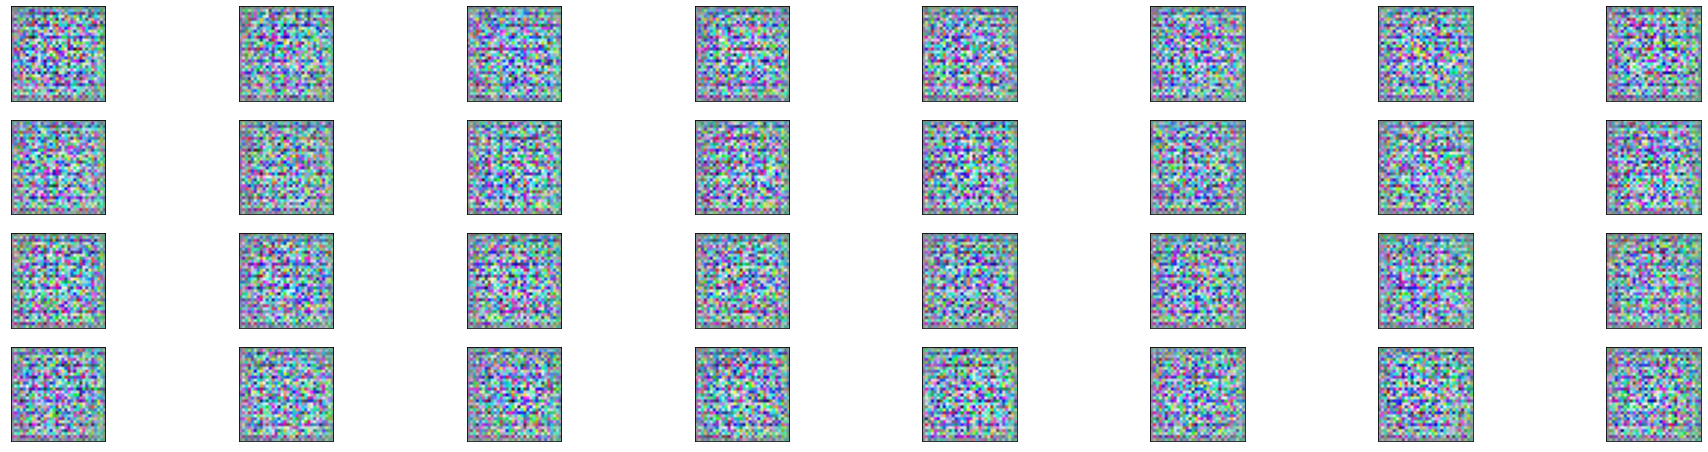

In [34]:
# Generate and display results from noise (TODO fix)
sample_size = img_size
z_size = 100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.cpu()

_ = view_samples(model(fixed_z))

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


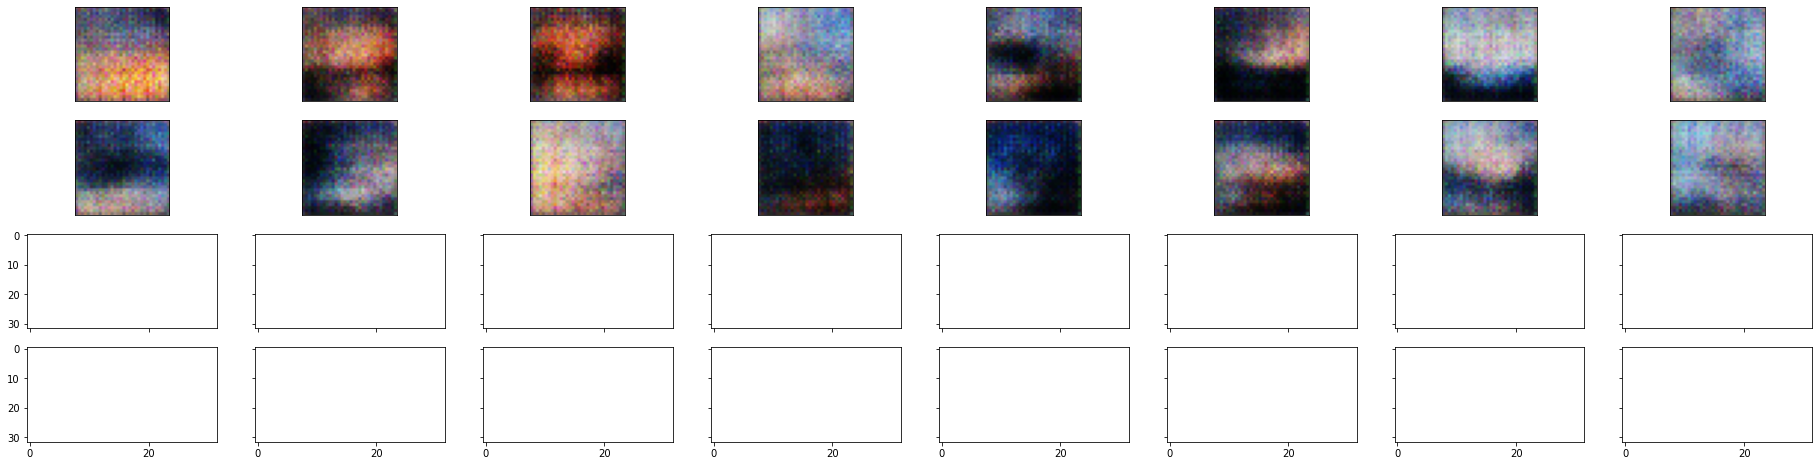

In [33]:
# Show samples from generator (taken while training)

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)[0]

_ = view_samples(samples)


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda)

